In [1]:
import sys
sys.path.insert(1, '/Users/linusrandud/Documents/UoM/ERP/MscDissertation/Deep-Opt')

In [2]:
import torch

from COProblems.MKP import MKP
from COProblems.QUBO import QUBO
from Models.DOAE import DOAE
from OptimAE import OptimAEHandler
import json

/Users/linusrandud/anaconda3/envs/myenv_3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import wandb
import matplotlib.pyplot as plt

In [4]:
# Initialize device
device = torch.device("cpu")
print(device)

# Define the file path and problem type
filename = 'ssjsp_20_05'
problem_type = 'QUBO'
use_wandb = False  # Set to True if using Weights & Biases
check_constraints = 'lagrangian' # {'binary', 'lagrangian', None}

json_file = f'../data/ssjsp/{filename}.json'
file_paths = [f'../data/qubo/{filename}.txt']
problem_size = int(filename.split('_')[1])
problem_size

cpu


20

In [5]:
def load_jobs_from_json(file_path):
    with open(file_path, 'r') as f:
        jobs = json.load(f)
    
    # Convert keys to integers
    jobs = {int(k): v for k, v in jobs.items()}
    
    return jobs

jobs = load_jobs_from_json(json_file)

In [6]:
jobs

{1: {'duration': 20, 'release': 0, 'deadline': 30, 'machine': 0},
 2: {'duration': 20, 'release': 10, 'deadline': 45, 'machine': 0},
 3: {'duration': 20, 'release': 20, 'deadline': 60, 'machine': 0},
 4: {'duration': 20, 'release': 30, 'deadline': 75, 'machine': 0},
 5: {'duration': 15, 'release': 40, 'deadline': 82, 'machine': 0},
 6: {'duration': 1, 'release': 47, 'deadline': 72, 'machine': 0},
 7: {'duration': 1, 'release': 48, 'deadline': 73, 'machine': 0},
 8: {'duration': 1, 'release': 48, 'deadline': 74, 'machine': 0},
 9: {'duration': 1, 'release': 49, 'deadline': 75, 'machine': 0},
 10: {'duration': 1, 'release': 49, 'deadline': 75, 'machine': 0},
 11: {'duration': 19, 'release': 0, 'deadline': 28, 'machine': 1},
 12: {'duration': 19, 'release': 9, 'deadline': 42, 'machine': 1},
 13: {'duration': 19, 'release': 19, 'deadline': 57, 'machine': 1},
 14: {'duration': 19, 'release': 28, 'deadline': 71, 'machine': 1},
 15: {'duration': 10, 'release': 38, 'deadline': 72, 'machine': 1

In [7]:
def calculate_percentage(data):
    # Determine the minimum release value and maximum deadline value in the dictionary
    min_release = min(item['release'] for item in data.values())
    max_deadline = max(item['deadline'] for item in data.values())

    # Total number of entries in the dictionary
    total_entries = len(data)
    
    # Count the number of entries with release == min_release and deadline == max_deadline
    count_matching_entries = sum(
        1 for item in data.values() if item['release'] == min_release and item['deadline'] == max_deadline
    )
    
    # Calculate the percentage
    percentage = (count_matching_entries / total_entries) * 100
    
    print(f'Problem instance has {percentage}% slackness')

# Parameters
params = {
    'change_tolerance': 20,
    'problem_size': problem_size,
    'pop_size': 1000,
    'dropout_prob': 0.2,
    'l1_coef': 0.0001,
    'l2_coef': 0.0001,
    'learning_rate': 0.002,
    'max_depth': 6,
    'compression_ratio': 0.8,
    'problem_instance_id': 0,
    'deepest_only': True,
    'encode': True,
    'repair_solutions': True,
    'patience': 5,  # Number of iterations to wait
    'delta_mean_population': 0.1,  # Threshold for mean population change
    'check_constraints': check_constraints,
    'penalty_mult': 5
}

# Initialize problem
if problem_type == 'QUBO':
    problem = QUBO(file_paths[0], params['problem_instance_id'], device)
    if check_constraints:
        problem.jobs = jobs
        calculate_percentage(jobs)
elif problem_type == 'MKP':
    problem = MKP(file_paths[0], file_paths[1], params['problem_instance_id'], device)
else:
    raise ValueError("Unsupported problem type")

# Unpack parameters
change_tolerance = params['change_tolerance']
problem_size = params['problem_size']
pop_size = params['pop_size']
dropout_prob = params['dropout_prob']
l1_coef = params['l1_coef']
l2_coef = params['l2_coef']
lr = params['learning_rate']
max_depth = params['max_depth']
compression_ratio = params['compression_ratio']
hidden_size = problem_size

# Initialize model and handler
model = DOAE(problem_size, dropout_prob, device)
handler = OptimAEHandler(model, problem, device)

if use_wandb:
    if check_constraints:
        wandb.init(project="Deep Optimization with Constraints", tags=[problem_type, 'Check Constraints'])
    else:
        wandb.init(project="Deep Optimization with Constraints", tags=[problem_type])
    wandb.config.update(params)
    wandb.log_artifact(file_paths[0], type='dataset')
    if problem_type == 'MKP':
        wandb.log_artifact(file_paths[1], type='dataset')

    # Log the job parameters as a separate file if needed
    job_params_path = 'job_params.json'
    with open(job_params_path, 'w') as f:
        json.dump(jobs, f)
    wandb.log_artifact(job_params_path, type='dataset')

# Generate initial population
population, fitnesses = handler.generate_population(pop_size, params['check_constraints'], params['penalty_mult'])
population, fitnesses, _, _ = handler.hilldescent(population, fitnesses, change_tolerance, params['check_constraints'], params['penalty_mult'])
handler.print_statistics_min(fitnesses)

total_eval = 0
depth = 0

# Store metrics for custom plotting
mean_fitnesses = []
min_max_fitnesses = []
total_evaluations = []
mean_fitness_changes = []

while True:
    if depth < max_depth:
        print("Adding layer")
        hidden_size = round(hidden_size * compression_ratio)
        model.transition(hidden_size)
        depth += 1
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_coef)
    
    print("Learning from population")
    handler.learn_from_population(population, optimizer, l1_coef=l1_coef, batch_size=pop_size)
    
    print("Optimising population")
    population, fitnesses, evaluations, done = handler.optimise_solutions_min(
        population, fitnesses, change_tolerance, encode=params['encode'], repair_solutions=params['repair_solutions'], deepest_only=params['deepest_only'], 
        check_constraints=params['check_constraints'], penalty_mult=params['penalty_mult']
    )
    handler.print_statistics_min(fitnesses)

    mean_fitness = fitnesses.mean().item()
    min_max_fitness = fitnesses.min().item()
    total_eval += evaluations

    mean_fitnesses.append(mean_fitness)
    min_max_fitnesses.append(min_max_fitness)
    total_evaluations.append(total_eval)

    if use_wandb:
        wandb.log({
            "mean_fitness": mean_fitness,
            "min_max_fitness": min_max_fitness,
            "total_eval": total_eval,
            "depth": depth
        })

    print(f"Evaluations: {total_eval}")
    
    if len(mean_fitnesses) > 1:
        mean_fitness_change = abs(mean_fitnesses[-1] - mean_fitnesses[-2])
        mean_fitness_changes.append(mean_fitness_change)
        
        if len(mean_fitness_changes) >= params['patience']:
            recent_changes = mean_fitness_changes[-params['patience']:]
            if all(change < params['delta_mean_population'] for change in recent_changes):
                print(f"Stopping early due to no significant change in mean fitness over the last {params['patience']} iterations.")
                break
    
    if done:
        print(f"Optimum solution found.")
        break

Instance has been loaded
Problem instance has 0.0% slackness
Min pop fitness: -9624.0, Mean pop fitness : -9289.15234375
Adding layer
Learning from population
Optimising population
Min pop fitness: -9624.0, Mean pop fitness : -9478.7177734375
Evaluations: 34255
Adding layer
Learning from population
Optimising population
Min pop fitness: -9624.0, Mean pop fitness : -9561.435546875
Evaluations: 67902
Adding layer
Learning from population
Optimising population
Min pop fitness: -9624.0, Mean pop fitness : -9586.205078125
Evaluations: 92835
Adding layer
Learning from population
Optimising population
Min pop fitness: -9624.0, Mean pop fitness : -9607.7685546875
Evaluations: 117742
Adding layer
Learning from population
Optimising population
Min pop fitness: -9624.0, Mean pop fitness : -9618.330078125
Evaluations: 139415
Adding layer
Learning from population
Optimising population
Min pop fitness: -9624.0, Mean pop fitness : -9622.017578125
Evaluations: 160555
Learning from population
Optimisin

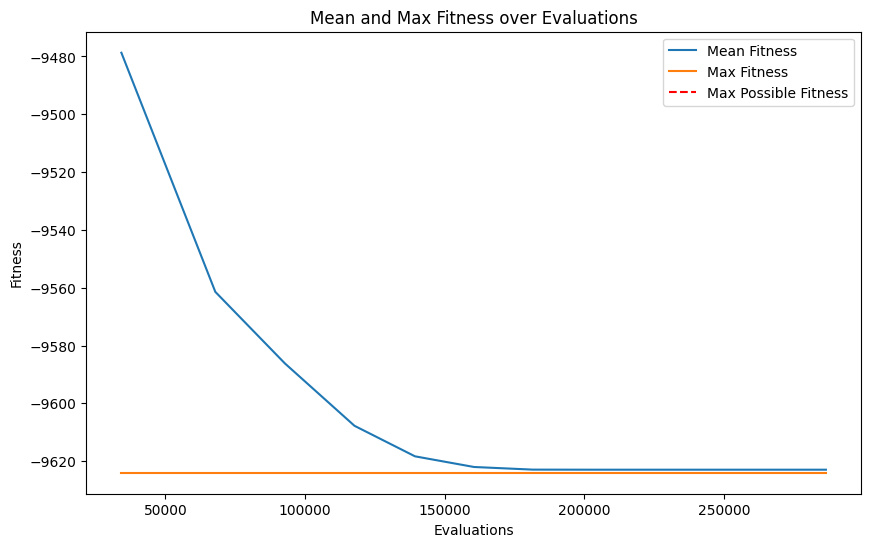

In [8]:
# Custom plot
plt.figure(figsize=(10, 6))
plt.plot(total_evaluations, mean_fitnesses, label='Mean Fitness')
plt.plot(total_evaluations, min_max_fitnesses, label='Max Fitness')
plt.axhline(y=problem.max_fitness, color='r', linestyle='--', label='Max Possible Fitness')
plt.xlabel('Evaluations')
plt.ylabel('Fitness')
plt.title('Mean and Max Fitness over Evaluations')
plt.legend()

# Save plot to W&B
# wandb.log({"fitness_plot": wandb.Image(plt)})

In [9]:
population

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])

In [10]:
fitnesses, len(fitnesses)

(tensor([-9624., -9624., -9624., -9624., -9624., -9624., -9624., -9624., -9624.,
         -9624., -9624., -9624., -9624., -9624., -9624., -9624., -9624., -9624.,
         -9624., -9624., -9624., -9624., -9624., -9624., -9624., -9624., -9624.,
         -9624., -9624., -9624., -9624., -9624., -9624., -9624., -9624., -9624.,
         -9624., -9624., -9624., -9624., -9624., -9624., -9624., -9624., -9624.,
         -9624., -9624., -9624., -9624., -9624., -9624., -9624., -9624., -9624.,
         -9624., -9624., -9624., -9624., -9624., -9624., -9624., -9624., -9624.,
         -9624., -9624., -9624., -9624., -9624., -9624., -9624., -9624., -9624.,
         -9624., -9624., -9624., -9624., -9624., -9624., -9624., -9624., -9624.,
         -9624., -9624., -9624., -9624., -9624., -9624., -9624., -9624., -9624.,
         -9624., -9624., -9624., -9624., -9624., -9624., -9624., -9624., -9624.,
         -9624., -9624., -9624., -9624., -9624., -9624., -9624., -9624., -9624.,
         -9624., -9624., -96

In [11]:
import numpy as np

In [12]:
def find_extreme_indices(fitnesses, mode='high'):
    """
    Returns the indices of the highest or lowest values in the list based on the mode.

    Args:
        fitnesses (list or torch.Tensor): A list or tensor of fitness values.
        mode (str): A string that can be either 'high' or 'low'. Defaults to 'high'.

    Returns:
        list: A list of indices corresponding to the extreme values.
    """
    if mode not in ['high', 'low']:
        raise ValueError("Mode should be either 'high' or 'low'")

    if mode == 'high':
        extreme_value = max(fitnesses)
    else:
        extreme_value = min(fitnesses)

    return [i for i, value in enumerate(fitnesses) if value == extreme_value]

In [13]:
def convert_tensor_to_unique_np_arrays(tensor):
    # Convert the tensor to a numpy array
    np_array = tensor.numpy()
    
    # Replace -1 with 0
    np_array[np_array == -1] = 0
    
    # Use a set to track unique arrays based on element ordering
    unique_arrays = set()
    
    # Create a list to store unique numpy arrays
    unique_np_arrays = []
    
    for arr in np_array:
        # Convert the array to a tuple (hashable type) for uniqueness check
        arr_tuple = tuple(arr)
        
        if arr_tuple not in unique_arrays:
            unique_arrays.add(arr_tuple)
            unique_np_arrays.append(arr)
    
    # Convert the list of unique arrays back to a numpy array
    unique_np_array = np.array(unique_np_arrays)
    
    return unique_np_array

In [14]:
def get_solutions(population, fitnesses, mode='low'):
    return convert_tensor_to_unique_np_arrays(population[find_extreme_indices(fitnesses, mode)])

In [15]:
def load_jobs_from_json(file_path):
    with open(file_path, 'r') as f:
        jobs = json.load(f)
    
    # Convert keys to integers
    jobs = {int(k): v for k, v in jobs.items()}
    
    return jobs

jobs = load_jobs_from_json(json_file)

In [16]:
import numpy as np

def check_constraints(solution, jobs):
    machine_jobs = [[], []]
    makespans = [0, 0]
    infeasible_count = 0
    
    # Distribute jobs to the respective machines
    for job_index, job_assignment in enumerate(solution):
        machine = int(job_assignment)
        job_key = job_index + 1
        job = jobs[job_key]
        machine_jobs[machine].append((job_key, job))
    
    # Validate each machine's job schedule
    for machine, assigned_jobs in enumerate(machine_jobs):
        current_time = 0
        # Sort jobs by release date first, then by deadline
        for job_key, job in sorted(assigned_jobs, key=lambda x: (x[1]['deadline'], x[1]['release'])):
            # Ensure the job starts at the earliest possible time that meets its release date
            if current_time < job['release']:
                current_time = job['release']
            current_time += job['duration']
            # Check if the job finishes before its deadline
            if current_time > job['deadline']:
                infeasible_count += 1
                print(f"Machine and Job makes it not feasible: {machine}/{job_key}")
                print(f"Current time: {current_time}, Job's deadline: {job['deadline']}")
        makespans[machine] = current_time
    
    if infeasible_count > 0:
        return False, infeasible_count, makespans
    return True, infeasible_count, makespans


In [17]:
solutions = get_solutions(population, fitnesses, mode='low')
len(solutions)

1

In [18]:
import math
print(len(solutions)/math.comb(len(solutions[0])*2, len(solutions[0])))

7.254444551924844e-12


In [19]:
solutions, solutions[0]

(array([[1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1.,
         1., 1., 1., 1.]], dtype=float32),
 array([1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1.,
        1., 1., 1.], dtype=float32))

In [20]:
all_makespans = []

for i, solution in enumerate(solutions):    
    machine_jobs = [[], []]
    makespans = [0, 0]

    # Distribute jobs to the respective machines
    for job_index, job_assignment in enumerate(solution):
        machine = int(job_assignment)
        job_key = job_index + 1
        job = jobs[job_key]
        makespans[machine] += job['duration']
    
    all_makespans.append(makespans)

In [21]:
all_makespans

[[106, 94]]

In [22]:
# Check all solutions
total_feasible_solutions = 0
total_infeasible_solutions = 0
logs = []

for i, solution in enumerate(solutions):
    feasible, infeasible_jobs, makespans = check_constraints(solution, jobs)
    if feasible:
        total_feasible_solutions += 1
    else:
        total_infeasible_solutions += 1
    
    # Accumulate logs
    logs.append({
        'solution_number': i + 1,
        'feasible': feasible,
        'infeasible_jobs': infeasible_jobs,
        'makespans': makespans
    })
    
    print(f"Solution {i + 1}: Feasible = {feasible}, Infeasible Jobs = {infeasible_jobs}, Makespans = {makespans}")
    print('')

# Log all solutions at once
# wandb.log({
#     'solutions': logs,
#     'total_feasible_solutions_count': total_feasible_solutions,
#     'total_infeasible_solutions': total_infeasible_solutions
# })

print(f'total_feasible_solutions: {total_feasible_solutions}')
print(f'total_infeasible_solutions: {total_infeasible_solutions}')

Machine and Job makes it not feasible: 0/14
Current time: 76, Job's deadline: 71
Machine and Job makes it not feasible: 0/15
Current time: 86, Job's deadline: 72
Machine and Job makes it not feasible: 0/4
Current time: 106, Job's deadline: 75
Machine and Job makes it not feasible: 1/9
Current time: 76, Job's deadline: 75
Machine and Job makes it not feasible: 1/10
Current time: 77, Job's deadline: 75
Machine and Job makes it not feasible: 1/20
Current time: 79, Job's deadline: 76
Machine and Job makes it not feasible: 1/5
Current time: 94, Job's deadline: 82
Solution 1: Feasible = False, Infeasible Jobs = 7, Makespans = [106, 94]

total_feasible_solutions: 0
total_infeasible_solutions: 1


In [17]:
# # Finish the W&B run
# wandb.finish()

depth,▁▂▄▅▇██████████████████████████████████
mean_fitness,█▆▅▄▄▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
min_max_fitness,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
total_eval,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
total_feasible_solutions_count,▁
total_infeasible_solutions,▁
depth,6
mean_fitness,-22499.9043
min_max_fitness,-22500.0
total_eval,8490933
total_feasible_solutions_count,11


# tests

In [18]:
# jobs = {
#     1: {"duration": 13, "release": 0, "deadline": 100},
#     2: {"duration": 23, "release": 5, "deadline": 100},
#     3: {"duration": 13, "release": 20, "deadline": 100},
#     4: {"duration": 13, "release": 30, "deadline": 100},
#     5: {"duration": 13, "release": 35, "deadline": 100},
#     6: {"duration": 13, "release": 0, "deadline": 100},
#     7: {"duration": 13, "release": 130, "deadline": 150},
#     8: {"duration": 13, "release": 0, "deadline": 150},
#     9: {"duration": 23, "release": 0, "deadline": 150},
#     10: {"duration": 13, "release": 0, "deadline": 150},
#     11: {"duration": 10, "release": 0, "deadline": 100},
#     12: {"duration": 10, "release": 20, "deadline": 100},
#     13: {"duration": 10, "release": 0, "deadline": 100},
#     14: {"duration": 20, "release": 0, "deadline": 100},
#     15: {"duration": 25, "release": 0, "deadline": 100},
#     16: {"duration": 20, "release": 100, "deadline": 120},
#     17: {"duration": 10, "release": 0, "deadline": 100},
#     18: {"duration": 15, "release": 0, "deadline": 150},
#     19: {"duration": 10, "release": 0, "deadline": 150},
#     20: {"duration": 20, "release": 0, "deadline": 150},
# }

# # Parameters
# params = {
#     'change_tolerance': 20,
#     'problem_size': 20,
#     'pop_size': 10000,
#     'dropout_prob': 0.2,
#     'l1_coef': 0.0001,
#     'l2_coef': 0.0001,
#     'learning_rate': 0.002,
#     'max_depth': 6,
#     'compression_ratio': 0.8,
#     'problem_instance_id': 0,
#     'deepest_only': True,
#     'encode': True,
#     'repair_solutions': True,
#     'patience': 5,  # Number of iterations to wait
#     'delta_mean_population': 0.1,  # Threshold for mean population change
#     'check_constraints': check_constraints
# }

# # Initialize problem
# if problem_type == 'QUBO':
#     problem = QUBO(file_paths[0], params['problem_instance_id'], device)
# elif problem_type == 'MKP':
#     problem = MKP(file_paths[0], file_paths[1], params['problem_instance_id'], device)
# else:
#     raise ValueError("Unsupported problem type")

# problem.jobs = jobs

# # Unpack parameters
# change_tolerance = params['change_tolerance']
# problem_size = params['problem_size']
# pop_size = params['pop_size']
# dropout_prob = params['dropout_prob']
# l1_coef = params['l1_coef']
# l2_coef = params['l2_coef']
# lr = params['learning_rate']
# max_depth = params['max_depth']
# compression_ratio = params['compression_ratio']
# hidden_size = problem_size

In [19]:
# # Initialize model and handler
# model = DOAE(problem_size, dropout_prob, device)
# handler = OptimAEHandler(model, problem, device)

In [20]:
# model, handler

In [21]:
# # Generate initial population
# population, fitnesses = handler.generate_population(pop_size)

In [22]:
# handler = OptimAEHandler(model, problem, device)

In [23]:
# # Generate initial population
# population, fitnesses = handler.generate_population(pop_size)
# population, fitnesses, _, _ = handler.hilldescent(population, fitnesses, change_tolerance)

In [24]:
# handler.print_statistics_min(fitnesses)

In [25]:
# total_eval = 0
# depth = 0

# # Store metrics for custom plotting
# mean_fitnesses = []
# min_max_fitnesses = []
# total_evaluations = []
# mean_fitness_changes = []

# while True:
#     if depth < max_depth:
#         print("Adding layer")
#         hidden_size = round(hidden_size * compression_ratio)
#         model.transition(hidden_size)
#         depth += 1
#         optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_coef)
    
#     print("Learning from population")
#     handler.learn_from_population(population, optimizer, l1_coef=l1_coef, batch_size=pop_size)
    
#     print("Optimising population")
#     population, fitnesses, evaluations, done = handler.optimise_solutions_min(
#         population, fitnesses, change_tolerance, encode=params['encode'], repair_solutions=params['repair_solutions'], deepest_only=params['deepest_only']
#     )
#     handler.print_statistics_min(fitnesses)

#     mean_fitness = fitnesses.mean().item()
#     min_max_fitness = fitnesses.min().item()
#     total_eval += evaluations

#     mean_fitnesses.append(mean_fitness)
#     min_max_fitnesses.append(min_max_fitness)
#     total_evaluations.append(total_eval)

#     # if use_wandb:
#     #     wandb.log({
#     #         "mean_fitness": mean_fitness,
#     #         "min_max_fitness": min_max_fitness,
#     #         "total_eval": total_eval,
#     #         "depth": depth
#     #     })

#     print(f"Evaluations: {total_eval}")
    
#     if len(mean_fitnesses) > 1:
#         mean_fitness_change = abs(mean_fitnesses[-1] - mean_fitnesses[-2])
#         mean_fitness_changes.append(mean_fitness_change)
        
#         if len(mean_fitness_changes) >= params['patience']:
#             recent_changes = mean_fitness_changes[-params['patience']:]
#             if all(change < params['delta_mean_population'] for change in recent_changes):
#                 print(f"Stopping early due to no significant change in mean fitness over the last {params['patience']} iterations.")
#                 break
    
#     if done:
#         print(f"Optimum solution found.")
#         break

In [26]:
# # Initialize model and handler
# model = DOAE(problem_size, dropout_prob, device)
# handler = OptimAEHandler(model, problem, device)

# # Generate initial population
# population, fitnesses = handler.generate_population(pop_size)
# population, fitnesses, _, _ = handler.hilldescent(population, fitnesses, change_tolerance, jobs, check_constraints)
# handler.print_statistics_min(fitnesses)

# total_eval = 0
# depth = 0

# # Store metrics for custom plotting
# mean_fitnesses = []
# min_max_fitnesses = []
# total_evaluations = []
# mean_fitness_changes = []

# while True:
#     if depth < max_depth:
#         print("Adding layer")
#         hidden_size = round(hidden_size * compression_ratio)
#         model.transition(hidden_size)
#         depth += 1
#         optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_coef)
    
#     print("Learning from population")
#     handler.learn_from_population(population, optimizer, l1_coef=l1_coef, batch_size=pop_size)
    
#     print("Optimising population")
#     population, fitnesses, evaluations, done = handler.optimise_solutions_min(
#         population, fitnesses, change_tolerance, encode=params['encode'], repair_solutions=params['repair_solutions'], deepest_only=params['deepest_only'], jobs=jobs, check_constraints=check_constraints
#     )
#     handler.print_statistics_min(fitnesses)

#     mean_fitness = fitnesses.mean().item()
#     min_max_fitness = fitnesses.min().item()
#     total_eval += evaluations

#     mean_fitnesses.append(mean_fitness)
#     min_max_fitnesses.append(min_max_fitness)
#     total_evaluations.append(total_eval)

#     if use_wandb:
#         wandb.log({
#             "mean_fitness": mean_fitness,
#             "min_max_fitness": min_max_fitness,
#             "total_eval": total_eval,
#             "depth": depth
#         })

#     print(f"Evaluations: {total_eval}")
    
#     if len(mean_fitnesses) > 1:
#         mean_fitness_change = abs(mean_fitnesses[-1] - mean_fitnesses[-2])
#         mean_fitness_changes.append(mean_fitness_change)
        
#         if len(mean_fitness_changes) >= params['patience']:
#             recent_changes = mean_fitness_changes[-params['patience']:]
#             if all(change < params['delta_mean_population'] for change in recent_changes):
#                 print(f"Stopping early due to no significant change in mean fitness over the last {params['patience']} iterations.")
#                 break
    
#     if done:
#         print(f"Optimum solution found.")
#         break